In [5]:
!pip install arch
!pip install pmdarima

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 10.6 MB/s eta 0:00:00


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from arch import arch_model
import warnings
import yfinance as yf
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
import statsmodels.api as sm

warnings.filterwarnings('ignore')

In [3]:
inf = yf.Ticker("TECHM.NS")
df = inf.history(period="10y").reset_index()
df['Date'] = pd.to_datetime(df['Date']).dt.date
df.set_index('Date', inplace=True)
df1 = pd.DataFrame(df['Close'], df.index, columns=['Close'])
df

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2013-09-02,264.805396,267.654928,259.787521,263.855560,2625912,0.0,0.0
2013-09-03,267.338333,275.359260,265.966352,268.719940,6256104,0.0,0.0
2013-09-04,270.561962,273.267577,266.848935,268.489563,3642560,0.0,0.0
2013-09-05,268.940528,269.429828,263.922654,265.265869,3071968,0.0,0.0
2013-09-06,264.421646,269.429918,259.624446,261.025238,2991140,0.0,0.0
...,...,...,...,...,...,...,...
2023-08-25,1190.000000,1197.199951,1178.449951,1189.500000,1213340,0.0,0.0
2023-08-28,1189.550049,1196.300049,1182.300049,1184.750000,950013,0.0,0.0
2023-08-29,1192.400024,1207.900024,1188.250000,1198.000000,1419344,0.0,0.0


In [4]:
train = df1[:-60]
test = df1[-60:]

In [6]:
from pmdarima import auto_arima

val_find = auto_arima(df1['Close'], trace=True, suppress_warnings=True)
val_find.summary()

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=19731.184, Time=6.32 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=19744.647, Time=0.41 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=19740.637, Time=0.37 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=19739.723, Time=0.81 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=19744.674, Time=0.13 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=19733.936, Time=2.48 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=19733.373, Time=3.34 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=19733.097, Time=11.03 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=19733.087, Time=10.90 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=19735.491, Time=1.91 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=19732.217, Time=5.75 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=19731.531, Time=5.07 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=19734.318, Time=6.76 sec
 ARIMA(2,1,2)(0,0,0)[0]             : AIC=19731.199, Time=1.13 sec

Best model:  ARI

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 2466
Model:               SARIMAX(2, 1, 2)   Log Likelihood               -9859.592
Date:                Thu, 31 Aug 2023   AIC                          19731.184
Time:                        14:51:49   BIC                          19766.043
Sample:                             0   HQIC                         19743.849
                               - 2466                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.7753      0.559      1.386      0.166      -0.321       1.871
ar.L1         -0.4618      0.139     -3.318      0.001      -0.735      -0.189
ar.L2         -0.5778      0.101     -5.741      0.000      -0.775      -0.381
ma.L1          0.5144      0.141      3.646      0.000       0.238       0.791
ma.L2          0.5403      0.109      4.949      0.000       0.326       0.754
sigma2       174.4945      2.559     68.199      0.000     169.480     179.509
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):              3326.18
Prob(Q):                              0.96   Prob(JB):                         0.00
Heteroskedasticity (H):               7.07   Skew:                            -0.21
Prob(H) (two-sided):                  0.00   Kurtosis:                         8.67
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

###**Building GARCH model**


In [13]:
returns = np.log(df['Close']).diff().dropna()

model = arch_model(returns, mean='Zero', vol='GARCH', p=1, q=1)
results = model.fit()

Iteration:      1,   Func. Count:      4,   Neg. LLF: -6381.511811740041
Optimization terminated successfully    (Exit mode 0)
            Current function value: -6381.511814294254
            Iterations: 5
            Function evaluations: 4
            Gradient evaluations: 1


###**Finding the value of the p parameter**
We can find the value of p by inspecting the PACF plot. The partial autocorrelation function plot can be used to draw a correlation between the time series and its lag while the contribution from intermediate lags can be ignored. This plotting will let us know about the lags that are not required in the autoregression part.

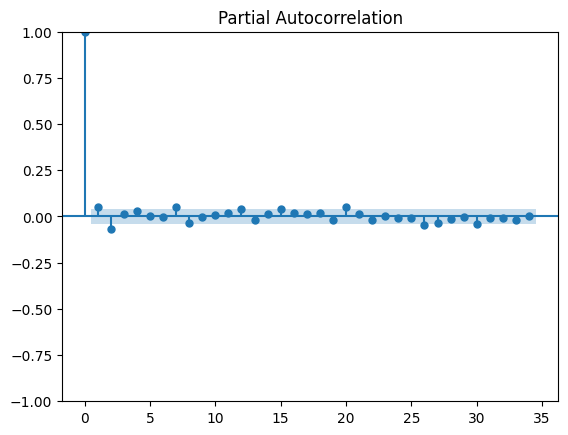

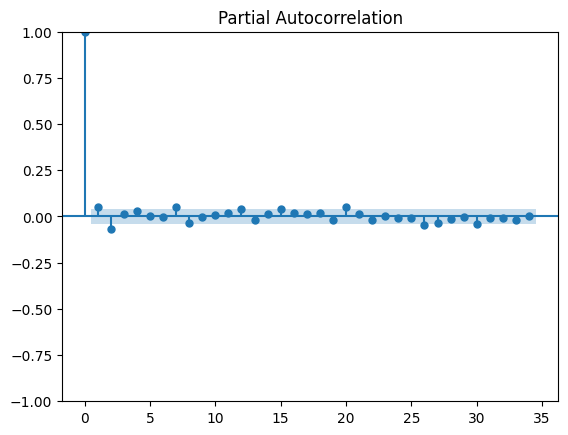

In [14]:
plot_pacf(df.Close.diff().dropna())

###**Finding the value of the q parameter**
To find out the value of q we can use the ACF plot. Which will tell us how much moving average is required to remove the autocorrelation from the stationary time series.

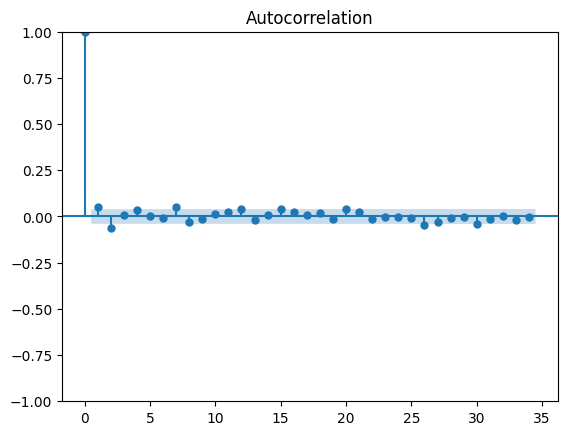

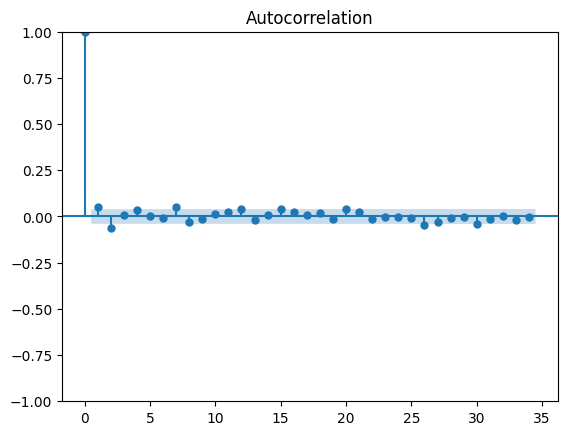

In [15]:
plot_acf(df.Close.diff().dropna())

**Model Training and Testing**

In [7]:
model = arch_model(train['Close'], mean='constant', vol='GARCH', p=2, q=2, dist='normal')
results = model.fit(disp='off')

In [9]:
start = len(train)
end = len(train) + len(test) - 1

pred = results.forecast(horizon=60)

print(pred.variance[-1:])

                     h.01           h.02           h.03           h.04  \
Date                                                                     
2023-06-06  402182.224761  402395.654416  402419.996971  402445.640226   

                     h.05           h.06           h.07           h.08  \
Date                                                                     
2023-06-06  402471.274535  402496.908905  402522.543274  402548.177644   

                     h.09           h.10  ...           h.51           h.52  \
Date                                      ...                                 
2023-06-06  402573.812013  402599.446383  ...  403650.455534  403676.089903   

                     h.53           h.54           h.55           h.56  \
Date                                                                     
2023-06-06  403701.724273  403727.358642  403752.993012  403778.627382   

                     h.57           h.58          h.59          h.60  
Date                  

In [11]:
rolling_predictions = []
test_size = 60
for i in range(test_size):
  train = df1['Close'][:-(test_size-i)]
  model = arch_model(train, p=2, q=2)
  model_fit = model.fit(disp='off')
  pred = model_fit.forecast(horizon=1)
  rolling_predictions.append(np.sqrt(pred.variance.values[-1,:][0]))
rolling_predictions = pd.Series(rolling_predictions, index=test['Close'].index[-60:])
print(rolling_predictions)

Date
2023-06-07    634.178386
2023-06-08    641.188935
2023-06-09    619.851906
2023-06-12    611.302847
2023-06-13    621.012246
2023-06-14    625.648654
2023-06-15    624.392443
2023-06-16    627.805977
2023-06-19    624.188047
2023-06-20    638.540445
2023-06-21    651.555973
2023-06-22    663.549964
2023-06-23    663.590108
2023-06-26    660.528733
2023-06-27    657.155804
2023-06-28    663.846186
2023-06-30    664.217599
2023-07-03    674.171275
2023-07-04    666.433777
2023-07-05    689.591564
2023-07-06    714.854448
2023-07-07    720.253491
2023-07-10    700.164772
2023-07-11    691.152105
2023-07-12    703.140684
2023-07-13    701.967990
2023-07-14    716.034183
2023-07-17    764.285910
2023-07-18    779.355107
2023-07-19    785.133878
2023-07-20    783.056836
2023-07-21    819.633419
2023-07-24    797.636546
2023-07-25    765.593207
2023-07-26    758.485656
2023-07-27    745.419406
2023-07-28    704.265338
2023-07-31    693.387076
2023-08-01    715.258368
2023-08-02    742.63

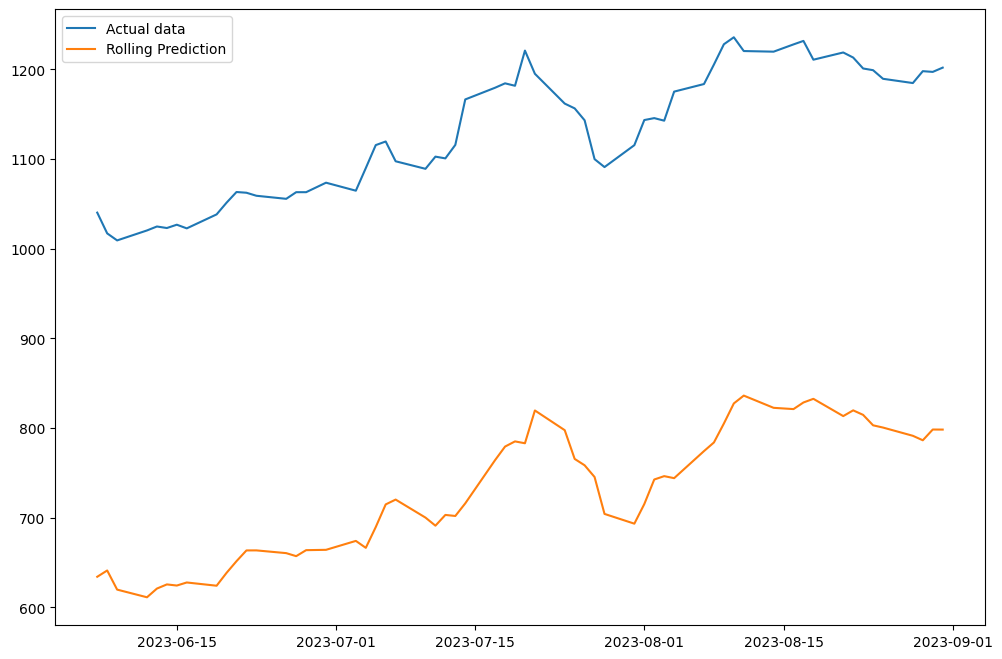

In [12]:
plt.figure(figsize=(12,8))
plt.plot(test['Close'], label='Actual data')
plt.plot(rolling_predictions, label='Rolling Prediction')
plt.legend()
plt.show()